In [53]:
import numpy as np
from numba import njit, prange
import matplotlib
from matplotlib import pylab
from matplotlib import pyplot as plt

### Simulation

In [2]:
dt = .001
tau = .1
noise_tau = .002
w11, w22 = 1, 1
w21, w12 = 1, 1
dur = 10
sgm = 10
threshold = 70
S = 576
R_initial = 32
eta = S*.1

In [3]:
@njit(parallel=True, fastmath=True)
def ave_choice(coh, a, b):

    alpha = a
    beta = b

    #S = (w11+w12-beta) * R_initial**2 + (1-alpha) * R_initial
    V1 = S*(1+coh)
    V2 = S*(1-coh)

    R1_arr = np.zeros(int(dur/dt))
    R2_arr = np.zeros(int(dur/dt))
    R1_arr[0], R2_arr[0] = R_initial, R_initial
    # R1_arr[0] = ((alpha-1) + np.sqrt((1-alpha)**2 + 4*S*(w11+w12-beta))) / (2*(w11+w12-beta))
    # R2_arr[0] = ((alpha-1) + np.sqrt((1-alpha)**2 + 4*S*(w22+w21-beta))) / (2*(w22+w21-beta))

    G1_arr = np.zeros(int(dur/dt))
    G2_arr = np.zeros(int(dur/dt))
    G1_arr[0], G2_arr[0] = (w11+w12-beta)*R1_arr[0], (w22+w21-beta)*R2_arr[0]

    D1_arr = np.zeros(int(dur/dt))
    D2_arr = np.zeros(int(dur/dt))
    D1_arr[0], D2_arr[0] = beta*R1_arr[0], beta*R2_arr[0]

    noise_R1 = np.zeros(int(dur/dt))
    noise_R2 = np.zeros(int(dur/dt))
    noise_G1 = np.zeros(int(dur/dt))
    noise_G2 = np.zeros(int(dur/dt))
    noise_D1 = np.zeros(int(dur/dt))
    noise_D2 = np.zeros(int(dur/dt))

    reaction_time = np.zeros(10240)
    choice = np.zeros(10240)

    for i in prange(10240):

        for ti in range(1, int(dur/dt)):

            if ti % 5 == 0:
                V1 = S*(1+coh) + np.random.randn() * eta
                V2 = S*(1-coh) + np.random.randn() * eta

            d_noiseR1 = (-noise_R1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseR2 = (-noise_R2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseG1 = (-noise_G1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseG2 = (-noise_G2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseD1 = (-noise_D1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseD2 = (-noise_D2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt

            d_R1 = (-R1_arr[ti-1] + (alpha * R1_arr[ti-1] + V1) / (1 + G1_arr[ti-1])) * dt/tau
            d_R2 = (-R2_arr[ti-1] + (alpha * R2_arr[ti-1] + V2) / (1 + G2_arr[ti-1])) * dt/tau
            d_G1 = (-G1_arr[ti-1] + w11*R1_arr[ti-1] + w12*R2_arr[ti-1] - D1_arr[ti-1]) * dt/tau
            d_G2 = (-G2_arr[ti-1] + w21*R1_arr[ti-1] + w22*R2_arr[ti-1] - D2_arr[ti-1]) * dt/tau
            d_D1 = (-D1_arr[ti-1] + beta*R1_arr[ti-1]) *dt/tau
            d_D2 = (-D2_arr[ti-1] + beta*R2_arr[ti-1]) *dt/tau

            noise_R1[ti] = noise_R1[ti-1] + d_noiseR1
            noise_R2[ti] = noise_R2[ti-1] + d_noiseR2
            noise_G1[ti] = noise_G1[ti-1] + d_noiseG1
            noise_G2[ti] = noise_G2[ti-1] + d_noiseG2
            noise_D1[ti] = noise_D1[ti-1] + d_noiseD1
            noise_D2[ti] = noise_D2[ti-1] + d_noiseD2

            R1_arr[ti] = max(R1_arr[ti-1] + d_R1 + noise_R1[ti], 0)
            R2_arr[ti] = max(R2_arr[ti-1] + d_R2 + noise_R2[ti], 0)
            G1_arr[ti] = max(G1_arr[ti-1] + d_G1 + noise_G1[ti], 0)
            G2_arr[ti] = max(G2_arr[ti-1] + d_G2 + noise_G2[ti], 0)
            D1_arr[ti] = max(D1_arr[ti-1] + d_D1 + noise_D1[ti], 0)
            D2_arr[ti] = max(D2_arr[ti-1] + d_D2 + noise_D2[ti], 0)

            if R1_arr[ti] > threshold:
                choice[i] = 1
                reaction_time[i] = ti
                break
            elif R2_arr[ti] > threshold:
                reaction_time[i] = ti
                break
            elif ti == dur/dt-1:
                reaction_time[i] = np.NAN
                choice[i] = np.NAN

    return reaction_time, choice

In [57]:
alpha = 0
beta1, beta2 = 0.9, 1.5
a_b1_RT, _ = ave_choice(.256, alpha, beta1)
a_b2_RT, _ = ave_choice(.256, alpha, beta2)
a_b1_RT, a_b2_RT = a_b1_RT / 1000, a_b2_RT / 1000

### Plotting

In [60]:
def plot_dist(s_beta_rt, l_beta_rt):
    num_bins = 4
    perc = 70
    x_lim = np.nanpercentile(np.concatenate((s_beta_rt, l_beta_rt)), 99.5)
    
    gap = (np.percentile(l_beta_rt, perc) - np.percentile(l_beta_rt, 100-perc)) / num_bins
    bins = np.arange(np.nanmin(np.concatenate((s_beta_rt, l_beta_rt))), 
                     np.nanmax(np.concatenate((s_beta_rt, l_beta_rt)))+gap, gap)
    
    s_beta_count, _ = np.histogram(s_beta_rt, bins=bins)
    l_beta_count, _ = np.histogram(l_beta_rt, bins=bins)
    bins_center = (bins + gap/2)[:-1]
    
    plt.plot(bins_center, s_beta_count, color='#86A3B8', label=f'α={alpha}, β={beta1}')
    plt.plot(bins_center, l_beta_count, color='#BD574E', label=f'α={alpha}, β={beta2}')
    
    plt.xlabel("Reaction Time (s)")
    plt.ylabel("Frequency")
    plt.xlim((0, x_lim))
    
    ax = plt.gca()
    ax.spines['bottom'].set_color('0')
    ax.spines['left'].set_color('0')
    ax.tick_params(bottom=True, left=True)
    
    font_size = 15
    params = {
         'figure.figsize': (4, 4),
         'legend.fontsize': font_size,
         'xtick.labelsize': font_size,
         'ytick.labelsize': font_size,
         'axes.labelsize': font_size,
         'axes.facecolor': 'white',
         'patch.linewidth': 0
    }
    pylab.rcParams.update(params)
    plt.tight_layout()
    plt.legend()

    plt.savefig(f'graphs/changing_beta_dist.tiff', format='tiff', bbox_inches='tight')

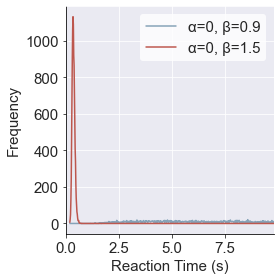

In [61]:
plot_dist(a_b1_RT, a_b2_RT)